# Variational Autoencoder for pan-cancer gene expression

**Alexander Titus 2018** -- extended from Gregory Way 2017

This script trains and outputs results for a [variational autoencoder (VAE)](https://arxiv.org/abs/1312.6114)
applied to breast cancer methylation data.

A VAE aproximates the data generating function for the cancer data and learns the lower dimensional manifold a tumor occupies in methylation space. By compressing the methylation space into lower dimensional space, the VAE would, ideally, learn biological principles, such as cancer hallmark pathway activations, that help explain how tumors are similar and different. The VAE is also a generative model with a latent space that can be interpolated to observe transitions between cancer states.

The particular model trained in this notebook consists of methylation input (100,000 most variably methylated CpGs by median absolute deviation) compressed down into two length 100 vectors (mean and variance encoded spaces) which are made deterministic through the reparameterization trick of sampling an epsilon vector from the uniform distribution. The encoded layer is then decoded back to original 100,000 dimensions through a single reconstruction layer. Included is a layer of batch normalization in the encoding step to prevent dead nodes. The encoding scheme also uses relu activation while the decoder uses a sigmoid activation to enforce positive activations. All weights are glorot uniform initialized. 

Another trick used here to encourage manifold learning is _warm start_ as discussed in [Sonderby et al. 2016](https://arxiv.org/abs/1602.02282). With warm starts, we add a parameter _beta_, which controls the contribution of the KL divergence loss in the total VAE loss (reconstruction + (beta * KL)). In this setting, the model begins training deterministically as a vanilla autoencoder (_beta_ = 0) and slowly ramps up after each epoch linearly until _beta_ = 1. After a parameter sweep, we observed that kappa has little influence in training, therefore, we set  _kappa_ = 1, which is a full VAE.

Much of this script is inspired by the [keras variational_autoencoder.py example](https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py)

## conda version 4.4.10
conda env create --force --file environment.yml

## activate environment
conda activate tybalt

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Layer, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras import backend as K
from keras import metrics, optimizers
from keras.callbacks import Callback
import keras

import pydot
import graphviz
from keras.utils import plot_model
from keras_tqdm import TQDMNotebookCallback
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

ImportError: No module named seaborn

In [ ]:
print(keras.__version__)
tf.__version__

In [4]:
%matplotlib inline
plt.style.use('seaborn-notebook')

In [5]:
sns.set(style="white", color_codes=True)
sns.set_context("paper", rc={"font.size":14,"axes.titlesize":15,"axes.labelsize":20,
                             'xtick.labelsize':14, 'ytick.labelsize':14})

## Load Functions and Classes

This will facilitate connections between layers and also custom hyperparameters

In [6]:
# Function for reparameterization trick to make model differentiable
def sampling(args):
    
    import tensorflow as tf
    # Function with args required for Keras Lambda function
    z_mean, z_log_var = args

    # Draw epsilon of the same shape from a standard normal distribution
    epsilon = K.random_normal(shape=tf.shape(z_mean), mean=0.,
                              stddev=epsilon_std)
    
    # The latent vector is non-deterministic and differentiable
    # in respect to z_mean and z_log_var
    z = z_mean + K.exp(z_log_var / 2) * epsilon
    return z


class CustomVariationalLayer(Layer):
    """
    Define a custom layer that learns and performs the training
    This function is borrowed from:
    https://github.com/fchollet/keras/blob/master/examples/variational_autoencoder.py
    """
    def __init__(self, **kwargs):
        # https://keras.io/layers/writing-your-own-keras-layers/
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x_input, x_decoded):
        reconstruction_loss = original_dim * metrics.binary_crossentropy(x_input, x_decoded)
        kl_loss = - 0.5 * K.sum(1 + z_log_var_encoded - K.square(z_mean_encoded) - 
                                K.exp(z_log_var_encoded), axis=-1)
        return K.mean(reconstruction_loss + (K.get_value(beta) * kl_loss))

    def call(self, inputs):
        x = inputs[0]
        x_decoded = inputs[1]
        loss = self.vae_loss(x, x_decoded)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

### Implementing Warm-up as described in Sonderby et al. LVAE

This is modified code from https://github.com/fchollet/keras/issues/2595

In [7]:
class WarmUpCallback(Callback):
    def __init__(self, beta, kappa):
        self.beta = beta
        self.kappa = kappa
    # Behavior on each epoch
    def on_epoch_end(self, epoch, logs={}):
        if K.get_value(self.beta) <= 1:
            K.set_value(self.beta, K.get_value(self.beta) + self.kappa)

In [8]:
np.random.seed(123)

## Load Methylation Data

In [9]:
# BreastCancerMethylation_top100kMAD_cpg.csv file = https://app.box.com/s/xzh0vu2e85pxusflxt47434yfxqi4355
methyl_file = os.path.join('data/raw', 'BreastCancerMethylation_top100kMAD_cpg.csv')
methyl_df = pd.read_csv(methyl_file, index_col = 0, header  = 0)
print(methyl_df.shape)
methyl_df.head(2)

(1230, 100000)


,cg01682111,cg18391209,cg27260772,cg27363327,cg17882374,cg16620382,cg23357130,cg05528899,cg01893212,cg13885357,...,cg26340740,cg07552322,cg26966083,cg03222009,cg13058453,cg17525418,cg17584014,cg01617071,cg00678668,cg01986630
CpG,,,,,,,,,,,,,,,,,,,,,
7796806090_R04C01,0.148795,0.827165,0.07093,0.068544,0.951175,0.055168,0.044086,0.203048,0.566052,0.566779,...,0.752437,0.240496,0.701855,0.717532,0.603018,0.718762,0.689224,0.514234,0.649068,0.473050
6285633051_R04C01,0.819280,0.238459,0.17315,0.074701,0.443478,0.137893,0.612504,0.952400,0.626088,0.387909,...,0.797816,0.142233,0.684140,0.785218,0.522061,0.925992,0.657774,0.577316,0.718510,0.539516


In [10]:
# Split 10% test set randomly
test_set_percent = 0.1
methyl_test_df = methyl_df.sample(frac=test_set_percent)
methyl_train_df = methyl_df.drop(methyl_test_df.index)

## Initialize variables and hyperparameters

In [30]:
# Set hyper parameters
original_dim = methyl_df.shape[1]
latent_dim = 100

batch_size = 50
epochs = 50
learning_rate = 0.0005

epsilon_std = 1.0
beta = K.variable(0)
kappa = 1

## Encoder

In [31]:
# Input place holder for methylation data with specific input size
methyl_input = Input(shape=(original_dim, ))

# Input layer is compressed into a mean and log variance vector of size `latent_dim`
# Each layer is initialized with glorot uniform weights and each step (dense connections,
# batch norm, and relu activation) are funneled separately
# Each vector of length `latent_dim` are connected to the rnaseq input tensor
z_mean_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(methyl_input)
z_mean_dense_batchnorm = BatchNormalization()(z_mean_dense_linear)
z_mean_encoded = Activation('relu')(z_mean_dense_batchnorm)

z_log_var_dense_linear = Dense(latent_dim, kernel_initializer='glorot_uniform')(methyl_input)
z_log_var_dense_batchnorm = BatchNormalization()(z_log_var_dense_linear)
z_log_var_encoded = Activation('relu')(z_log_var_dense_batchnorm)

# return the encoded and randomly sampled z vector
# Takes two keras layers as input to the custom sampling function layer with a `latent_dim` output
z = Lambda(sampling, output_shape=(latent_dim, ))([z_mean_encoded, z_log_var_encoded])

## Decoder

In [32]:
# The decoding layer is much simpler with a single layer and sigmoid activation
decoder_to_reconstruct = Dense(original_dim, kernel_initializer='glorot_uniform', activation='sigmoid')
methyl_reconstruct = decoder_to_reconstruct(z)

## Connect the encoder and decoder to make the VAE

The `CustomVariationalLayer()` includes the VAE loss function (reconstruction + (beta * KL)), which is what will drive our model to learn an interpretable representation of gene expression space.

The VAE is compiled with an Adam optimizer and built-in custom loss function. The `loss_weights` parameter ensures beta is updated at each epoch end callback

In [33]:
adam = optimizers.Adam(lr=learning_rate)
vae_layer = CustomVariationalLayer()([methyl_input, methyl_reconstruct])
vae = Model(methyl_input, vae_layer)
vae.compile(optimizer=adam, loss=None, loss_weights=[beta])

vae.summary()

C:\Users\atitus\Anaconda3\envs\tybalt\lib\site-packages\ipykernel\__main__.py:4: UserWarning: Output "custom_variational_layer_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_2" during training.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100000)       0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 100)          10000100    input_3[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 100)          10000100    input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 100)          400         dense_4[0][0]                    
__________________________________________________________________________________________________
batch_norm

In [34]:
# Visualize the connections of the custom VAE model
#output_model_file = os.path.join('figures', 'onehidden_vae_architecture.png')
#plot_model(vae, to_file=output_model_file)

#SVG(model_to_dot(vae).create(prog='dot', format='svg'))

## Train the model

The training data is shuffled after every epoch and 10% of the data is heldout for calculating validation loss.

In [35]:
%%time
hist = vae.fit(np.array(methyl_train_df),
               shuffle=True,
               epochs=epochs,
               verbose=0,
               batch_size=batch_size,
               validation_data=(np.array(methyl_test_df), None),
               callbacks=[WarmUpCallback(beta, kappa),
                          TQDMNotebookCallback(leave_inner=True, leave_outer=True)])

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.



Wall time: 22min 20s


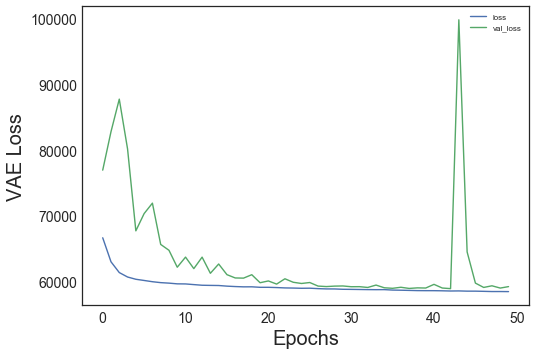

In [36]:
# Visualize training performance
history_df = pd.DataFrame(hist.history)
hist_plot_file = os.path.join('figures', 'onehidden_vae_training.pdf')
ax = history_df.plot()
ax.set_xlabel('Epochs')
ax.set_ylabel('VAE Loss')
fig = ax.get_figure()
fig.savefig(hist_plot_file)

## Compile and output trained models

We are interested in:

1. The model to encode/compress the input methylation data
  * Can be possibly used to compress other tumors
2. The model to decode/decompress the latent space back into methylation space
  * This is our generative model
3. The latent space compression of all breast cancer samples
  * Non-linear reduced dimension representation of tumors can be used as features for various tasks
    * Supervised learning tasks predicting specific methylation events
    * Interpolating across this space to observe how methylation changes between two cancer states
4. The weights used to compress each latent node
  * Potentially indicate learned biology differentially activating tumors

### Encoder model

In [37]:
# Model to compress input
encoder = Model(methyl_input, z_mean_encoded)

In [38]:
# Encode methylation into the hidden/latent representation - and save output
encoded_methyl_df = encoder.predict_on_batch(methyl_df)
encoded_methyl_df = pd.DataFrame(encoded_methyl_df, index=methyl_df.index)

encoded_methyl_df.columns.name = 'sample_id'
encoded_methyl_df.columns = encoded_methyl_df.columns + 1
#encoded_file = os.path.join('data', 'encoded_methyl_onehidden_warmup_batchnorm_100k_2.tsv')
#encoded_file = os.path.join('data', 'encoded_methyl_onehidden_warmup_batchnorm_100k_3.tsv')
encoded_file = os.path.join('data', 'encoded_methyl_onehidden_warmup_batchnorm_100k_100.tsv')

encoded_methyl_df.to_csv(encoded_file, sep='\t')

### Decoder (generative) model

In [39]:
# build a generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim, ))  # can generate from any sampled z vector
_x_decoded_mean = decoder_to_reconstruct(decoder_input)
decoder = Model(decoder_input, _x_decoded_mean)

## Save the encoder/decoder models for future investigation

In [40]:
encoder_model_file = os.path.join('models', 'encoder_onehidden_vae_100k_2.hdf5')
decoder_model_file = os.path.join('models', 'decoder_onehidden_vae_100k_2.hdf5')

#encoder.save(encoder_model_file)
#decoder.save(decoder_model_file)

##  Model Interpretation - Sanity Check


###  Observe the distribution of node activations.

We want to ensure that the model is learning a distribution of feature activations, and not zeroing out features.

In [41]:
# What are the most and least activated nodes
sum_node_activity = encoded_methyl_df.sum(axis=0).sort_values(ascending=False)

# Top 10 most active nodes
print(sum_node_activity.head(10))

# Bottom 10 least active nodes
sum_node_activity.tail(10)

sample_id
63    4038.473145
37    2433.747070
22    2425.689941
92    2424.977051
36    2240.768311
4     2216.216797
98    2158.351562
25    2005.620117
1     1971.211304
48    1901.296631
dtype: float32


sample_id
11    412.068726
58    386.426971
68    386.295135
73    374.845093
23    359.698944
17    314.072388
82    292.602905
62    235.176392
85    227.157471
45    131.961945
dtype: float32

sample_id
63    4038.473145
37    2433.747070
22    2425.689941
92    2424.977051
36    2240.768311
4     2216.216797
98    2158.351562
25    2005.620117
1     1971.211304
48    1901.296631
79    1859.887939
19    1852.519165
64    1820.210205
59    1765.718262
33    1738.396484
76    1705.224976
69    1700.465576
30    1660.718628
26    1635.147705
56    1599.621582
10    1491.937622
61    1491.054077
72    1446.554932
90    1420.479126
13    1406.775146
99    1363.797852
5     1360.532471
95    1328.148682
89    1279.744507
66    1275.218628
         ...     
78     622.620239
53     620.383423
14     569.879883
54     567.975647
9      565.606567
20     554.307373
35     550.734741
12     548.464294
49     545.699280
43     544.569580
38     527.823669
24     491.920898
87     490.506134
94     474.445435
39     470.159637
3      468.353210
84     463.197601
74     456.563446
88     452.728607
81     447.469543
11     412.068726
58     386.426971
68     386.295135
73     374.845093


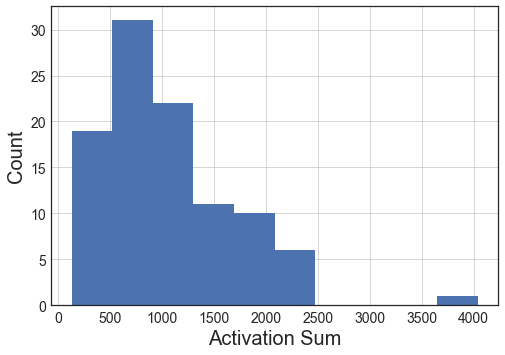

In [42]:
# Histogram of node activity for all 100 latent features
sum_node_activity.hist()
plt.xlabel('Activation Sum')
plt.ylabel('Count');
sum_node_activity

What does an example distribution of two latent features look like?

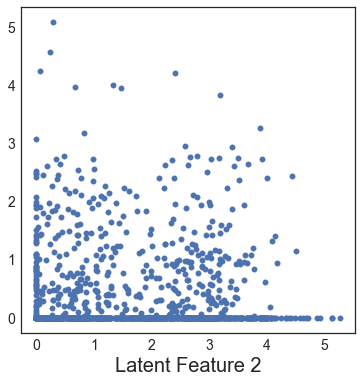

In [43]:
# Example of node activation distribution for the first two latent features
plt.figure(figsize=(6, 6))
plt.scatter(encoded_methyl_df.iloc[:, 0], encoded_methyl_df.iloc[:, 2])
plt.xlabel('Latent Feature 1')
plt.xlabel('Latent Feature 2');

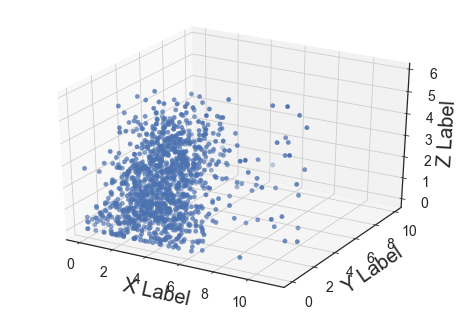

In [48]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = encoded_methyl_df.iloc[:, 62]
ys = encoded_methyl_df.iloc[:, 36]
zs = encoded_methyl_df.iloc[:, 21]
ax.scatter(xs, ys, zs)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

###  Observe reconstruction fidelity

In [45]:
# How well does the model reconstruct the input methylation data
input_methyl_reconstruct = decoder.predict(np.array(encoded_methyl_df))
input_methyl_reconstruct = pd.DataFrame(input_methyl_reconstruct, index=methyl_df.index,
                                        columns=methyl_df.columns)
input_methyl_reconstruct.head(2)

,cg01682111,cg18391209,cg27260772,cg27363327,cg17882374,cg16620382,cg23357130,cg05528899,cg01893212,cg13885357,...,cg26340740,cg07552322,cg26966083,cg03222009,cg13058453,cg17525418,cg17584014,cg01617071,cg00678668,cg01986630
CpG,,,,,,,,,,,,,,,,,,,,,
7796806090_R04C01,0.278768,0.510171,0.275315,0.419898,0.810312,0.428347,0.349760,0.614235,0.31760,0.453203,...,0.826854,0.176029,0.674666,0.852578,0.542331,0.843536,0.568932,0.559831,0.808316,0.635946
6285633051_R04C01,0.546676,0.508289,0.194895,0.529796,0.504901,0.540321,0.321682,0.579690,0.54355,0.502641,...,0.861147,0.149234,0.689864,0.888266,0.554548,0.886767,0.555312,0.645130,0.847621,0.731068


In [46]:
reconstruction_fidelity = methyl_df - input_methyl_reconstruct

cpg_mean = reconstruction_fidelity.mean(axis=0)
cpg_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(methyl_df.shape[0])
cpg_summary = pd.DataFrame([cpg_mean, cpg_abssum], index=['CpG mean', 'CpG abs(sum)']).T
cpg_summary.sort_values(by='CpG abs(sum)', ascending=False).head()

,CpG mean,CpG abs(sum)
cg18391209,-0.037168,0.300023
cg05528899,0.012118,0.279065
cg24506221,0.003658,0.264213
cg04131969,-0.016613,0.261929
cg12036633,-0.021231,0.261525


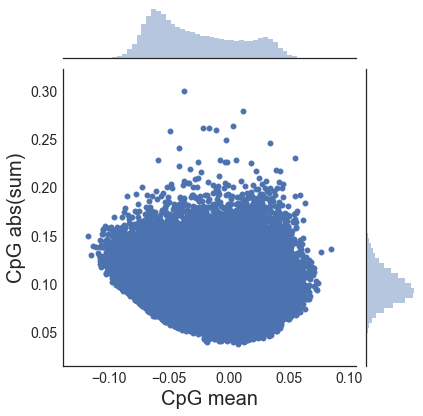

In [47]:
# Mean of cpg reconstruction vs. absolute reconstructed difference per sample
g = sns.jointplot('CpG mean', 'CpG abs(sum)', data=cpg_summary, stat_func=None);